# Inferring $R_t$ values from pyEpiabm using an SEIR model

In this notebook we use prevalence and incidence rates from pyEpiabm to infer the $\beta$, $\gamma$ and $\kappa$ values of the
SEIR model using `seirmo`. We then use $\beta$, $\gamma$ and $\kappa$  to calculate $R_t$ and then compare it to the true underlying
values.

## Plotting output data from the Gibraltar simulation

This notebook takes data from the gibraltar_example of pyEpiabm.

This simulation was run over 90 days with a total population of 33078 and initial infected number of 100.

### SIR Plot for Gibraltar

![SIR Plot](gibraltar_outputs/simulation_flow_SIR_plot.png)

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [4]:
np.mean(np.array([0.487464241, 1, 1.229764827, 1.312453175, 1.307955665, 1.251658756, 
          1.166040358, 1.065716869, 0.960199498, 0.855580145, 0.755628835, 
          0.662534099, 0.577412896, 0.500665739]) * np.array([i for i in range(14)]))

5.500489709785714

Text(0.5, 1.0, 'Underlying prevalence for Gibraltar simulation')

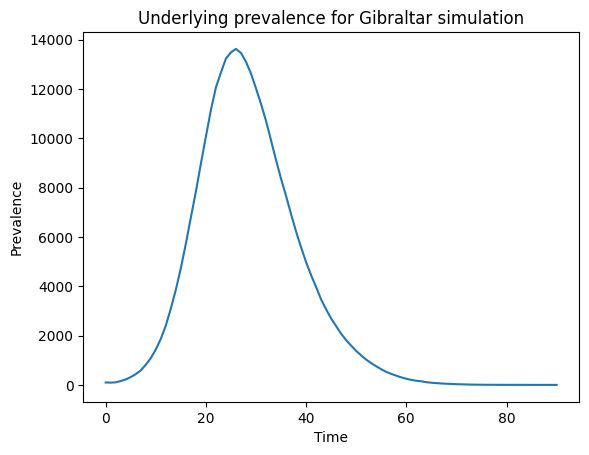

In [2]:
seir_data = pd.read_csv("gibraltar_outputs/inf_status_history.csv")
times = seir_data["time"]
# Get the true result from seir_data
susceptible_list = []
exposed_list = []
infected_list = []
recovered_list = []
for t in range(91):
    num = seir_data.iloc[t, 1:].value_counts().get(3, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(4, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(5, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(6, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(7, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(8, 0)
    susceptible_list.append(seir_data.iloc[t, 1:].value_counts().get(1, 0))
    exposed_list.append(seir_data.iloc[t, 1:].value_counts().get(2, 0))
    infected_list.append(num)
    recovered_list.append(seir_data.iloc[t, 1:].value_counts().get(9, 0) + seir_data.iloc[t, 1:].value_counts().get(10, 0))
susceptible = np.array(susceptible_list)
exposed = np.array(exposed_list)
infected = np.array(infected_list)
recovered = np.array(recovered_list)
plt.plot(times, infected)
plt.xlabel("Time")
plt.ylabel("Prevalence")
plt.title("Underlying prevalence for Gibraltar simulation")

### Create $R_t$ plot

Simulations in pyEpiabm produce true $R_t$ values for each time step in a file named `secondary_infections.csv`. 

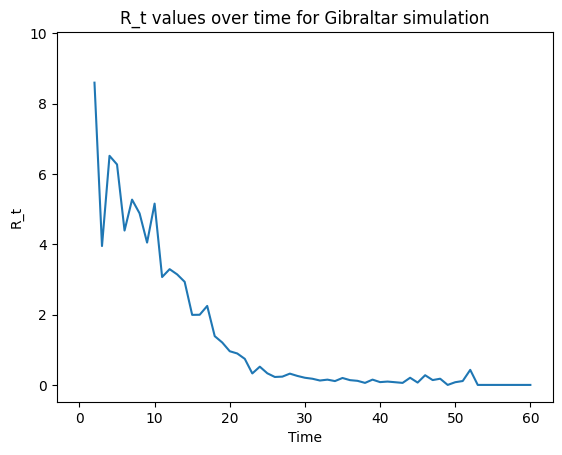

<Figure size 640x480 with 0 Axes>

In [3]:
secondary_infections_data = pd.read_csv("gibraltar_outputs/secondary_infections.csv")
plt.plot(secondary_infections_data["time"], secondary_infections_data["R_t"])
plt.xlabel("Time")
plt.ylabel("R_t")
plt.title("R_t values over time for Gibraltar simulation")
plt.show()
plt.savefig("gibraltar_outputs/simulation_flow_R_t.png")

### Create secondary infections histogram

This file also contains data for the secondary infections of each person.

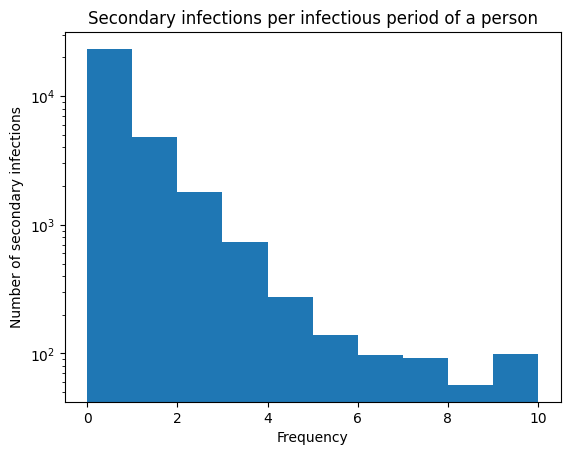

<Figure size 640x480 with 0 Axes>

In [4]:
secondary_infections_data.dropna()
secondary_infections_only = secondary_infections_data.iloc[:, 2:-1].to_numpy()
secondary_infections_array = secondary_infections_only.flatten()
plt.hist(secondary_infections_array, range=(0, 10), log=True)
plt.xlabel("Frequency")
plt.ylabel("Number of secondary infections")
plt.title("Secondary infections per infectious period of a person")
plt.show()
plt.savefig("gibraltar_outputs/simulation_flow_secondary_infections.png")

## Crude estimates for $\beta$, $\kappa$ and $\gamma$

In this section, we will use the governing ODEs:

\begin{equation}
    \frac{dS(t)}{dt} = -\beta S(t)I(t),
\end{equation}
\begin{equation}                \frac{dE(t)}{dt} =      \beta S(t)I(t) - \kappa E(t),
\end{equation}
\begin{equation}
    \frac{dI(t)}{dt} = \kappa E(t) - \gamma I(t), 
\end{equation}

\begin{equation}
    \frac{dR(t)}{dt} = \gamma I(t),
\end{equation}

to give crude estimates for what $\beta$, $\kappa$ and $\gamma$ should be as a comparison.

We will do this by estimating the gradients of the true compartmental values using `np.gradient` to retrieve an array
of estimates for $\beta$ (eq. 1) then $\gamma$ (eq. 4) and then $\kappa$ (eq. 3).

In [5]:
dS_dt = np.gradient(susceptible)
dE_dt = np.gradient(exposed)
dI_dt = np.gradient(infected)
dR_dt = np.gradient(recovered)

In [6]:
pop_size = 33078
beta_estimate = - dS_dt * pop_size / (susceptible * infected)
gamma_estimate = dR_dt / infected
kappa_estimate_eq_3 = (dI_dt + gamma_estimate * infected) / exposed
kappa_estimate_eq_2 = (beta_estimate / pop_size * susceptible * infected - dE_dt) / exposed

C:\Users\matth\AppData\Local\Temp\ipykernel_31772\3301848107.py:4: RuntimeWarning: divide by zero encountered in divide
  kappa_estimate_eq_3 = (dI_dt + gamma_estimate * infected) / exposed
C:\Users\matth\AppData\Local\Temp\ipykernel_31772\3301848107.py:4: RuntimeWarning: invalid value encountered in divide
  kappa_estimate_eq_3 = (dI_dt + gamma_estimate * infected) / exposed
C:\Users\matth\AppData\Local\Temp\ipykernel_31772\3301848107.py:5: RuntimeWarning: divide by zero encountered in divide
  kappa_estimate_eq_2 = (beta_estimate / pop_size * susceptible * infected - dE_dt) / exposed
C:\Users\matth\AppData\Local\Temp\ipykernel_31772\3301848107.py:5: RuntimeWarning: invalid value encountered in divide
  kappa_estimate_eq_2 = (beta_estimate / pop_size * susceptible * infected - dE_dt) / exposed


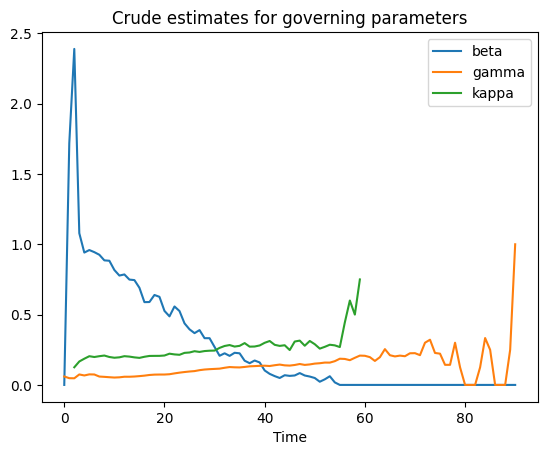

In [7]:
plt.plot(times, beta_estimate, label="beta")
plt.plot(times, gamma_estimate, label="gamma")
plt.plot(times, kappa_estimate_eq_3, label="kappa")
plt.xlabel("Time")
plt.legend()
plt.title("Crude estimates for governing parameters")
plt.savefig("gibraltar_outputs/crude_estimates.png")

In [20]:
param_df = pd.DataFrame({"beta": beta_estimate, "gamma": gamma_estimate, "kappa_eq_3": kappa_estimate_eq_3,
                         "kappa_eq_2": kappa_estimate_eq_2})
param_df.replace(np.inf, 0, inplace=True)

# We replace any zeros with NaNs as these will not contribute to the beta, gamma and kappa values
param_df.replace(0, np.nan, inplace=True)
print(f"Mean beta: {np.mean(param_df["beta"])}, std dev beta: {np.std(param_df["beta"])}")
print(f"Mean gamma: {np.mean(param_df["gamma"])}, std dev gamma: {np.std(param_df["gamma"])}")
print(f"Mean kappa (eq 2): {np.mean(param_df["kappa_eq_2"])}, std dev kappa (eq 2): {np.std(param_df["kappa_eq_2"])}")
print(f"Mean kappa (eq 3): {np.mean(param_df["kappa_eq_3"])}, std dev kappa (eq 3): {np.std(param_df["kappa_eq_3"])}")

Mean beta: 0.46300262121539953, std dev beta: 0.4467794222489285
Mean gamma: 0.15108294716739593, std dev gamma: 0.11456230832970896
Mean kappa (eq 2): 0.2652491831785554, std dev kappa (eq 2): 0.09845022763699664
Mean kappa (eq 3): 0.2652491831785554, std dev kappa (eq 3): 0.09845022763699664


Text(0.5, 1.0, 'Crude estimates for beta, gamma and kappa at each timepoint')

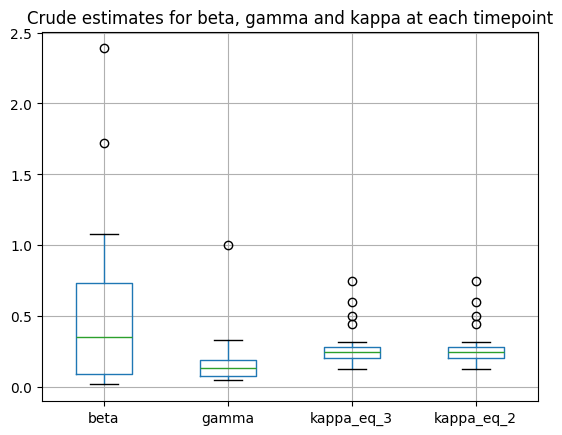

In [21]:
param_df.boxplot()
plt.title("Crude estimates for beta, gamma and kappa at each timepoint")

We can see from these crude estimates that $\beta$ has a wide range of values and will be hard to estimate, but $\kappa$
is constrained around $0.265$. In order to reduce the parameter space of the model, we fix $\kappa$ at this value. Without 
fixing $\kappa$, there is a high correlation between $\beta$ and $\kappa$ (see pairwise plots from inference below).

![Pairwise plots](inference_outputs/pairwise_no_ics.png)

### Crude estimate of $R_t$

Now we will move on to estimating the value of $R_t$. The effective reproduction number, $R_t$, is defined as:

$$R_{t} = \frac{\beta(t)}{N\gamma(t)}S(t),$$

where $\beta(t)$ and $\gamma(t)$ are as defined previously, $N$ is the total population and $S(t)$ is the number of susceptible people at time $t$.

In [25]:
crude_R_t = param_df['beta'] * susceptible / (pop_size * param_df['gamma'])
mean_crude_R_t = np.mean(param_df['beta']) * susceptible / (pop_size * np.mean(param_df['gamma']))

Text(0.5, 1.0, 'Comparing crude estimate of R_t to the true curve')

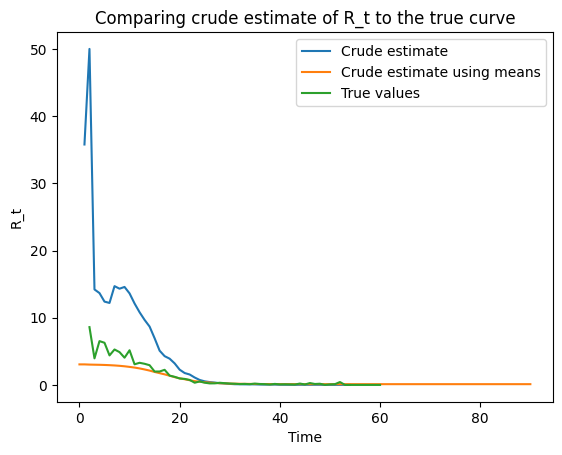

In [27]:
plt.plot(times, crude_R_t, label='Crude estimate')
plt.plot(times, mean_crude_R_t, label='Crude estimate using means')
plt.plot(times, secondary_infections_data['R_t'], label='True values')
plt.xlabel("Time")
plt.ylabel("R_t")
plt.legend()
plt.title("Comparing crude estimate of R_t to the true curve")

## Model Inference

### Set up

First, we normalise the data. Here is a description of our parameters:
* $S(0)$, $E(0)$, $I(0)$, $R(0)$ - Initial $S$, $E$, $I$ and $R$ values
* $\beta$, $\kappa$, $\gamma$ - Infection Rate, Incubation Rate and Recovery Rate respectively
* $\sigma_{S}$, $\sigma_{E}$, $\sigma_{I}$, $\sigma_{R}$ - The 4 hyperparameters controlling each respective log prior

In [13]:
all_data = np.array([susceptible, exposed, infected, recovered]).transpose()
pop_size = 33078
initial_infected = 100
all_data = all_data / pop_size

### PINTS ForwardModel

Next, we create the forward model used to perform inference. We will be using a `ReducedModel` from `seirmo` to fix/specify specific parameters
to reduce the dimensions of the parameter space. These values are described in the table below.

|Parameter|Value|Reasoning|
|---|---|-------|
|$S(0)$|$1 - I(0)$|The total of all compartments must add up to $1$ for all time (after scaling out by `pop_size`).|
|$E(0)$|$0$|We can safely assume that no-one has been exposed at the start of the simulation.|
|$I(0)$|$\frac{100}{33078}$|We know that there were $100$ initial infected, and we scale out by `pop_size`.|
|$R(0)$|$0$|We also enforce that no-one has recovered at the start of the simulation.|
|$\kappa$|$0.265$|From the reasoning in the crude estimates section, we fix $\kappa$ at this value.|

In [47]:
import seirmo
import pints

class SEIRModel1(pints.ForwardModel):
    def __init__(self):
        super(SEIRModel1, self).__init__()

        seir_model = seirmo.SEIRModel()
        self._model = seirmo.ReducedModel(seir_model)
        fixed_parameters = {"E0": 0, "R0": 0}
        self._model.fix_parameters(fixed_parameters)

    def n_outputs(self):
        # Returns number of model outputs.
        # Returns the S, E, I and R values at each timestep
        return 4

    def n_parameters(self):
        # Returns number of parameters, i.e. I(0), beta, kappa and gamma
        return 4

    def n_fixed_parameters(self):
        # Returns number of fixed parameters, i.e. 3 initial conditions (S(0), E(0), and R(0))
        return 3

    def simulate(self, parameters, times):
        # This ensures that we are taking the prevalence
        self._model.set_outputs(["S", "E", "I", "R"])
        parameters = np.insert(parameters, 0, 1 - parameters[0])
        compartmental_results = self._model.simulate(parameters=parameters, times=times)

        return compartmental_results

In [48]:
import seirmo
import pints

class SEIRModel2(pints.ForwardModel):
    def __init__(self, pop_size, initial_infected, kappa = None):
        super(SEIRModel2, self).__init__()

        seir_model = seirmo.SEIRModel()
        self._model = seirmo.ReducedModel(seir_model)
        fixed_parameters = {"S0": 1 - initial_infected / pop_size, "E0": 0, "I0": initial_infected / pop_size, "R0": 0}
        if kappa:
            fixed_parameters["beta"] = kappa
        self._model.fix_parameters(fixed_parameters)
        self._kappa = kappa

    def n_outputs(self):
        # Returns number of model outputs.
        # Returns the S, E, I and R values at each timestep
        return 4

    def n_parameters(self):
        # Returns number of parameters, i.e. some of beta, kappa and gamma
        if self._kappa:
            return 2
        return 3

    def n_fixed_parameters(self):
        # Returns number of fixed parameters, i.e. 4 initial conditions (S(0), E(0), I(0) and R(0)) and potentially kappa
        if self._kappa:
            return 5
        return 4

    def simulate(self, parameters, times):
        # This ensures that we are taking the prevalence
        self._model.set_outputs(["S", "E", "I", "R"])
        compartmental_results = self._model.simulate(parameters=parameters, times=times)

        return compartmental_results

### PINTS `MultiOutputProblem` and `GaussianLogLikelihood`

We choose a Gaussian log-likelihood and an array of Gaussian log-priors for each of the different parameters of the model.

In [119]:
# Create log-likelihood
pints_model = SEIRModel1()
problem = pints.MultiOutputProblem(pints_model, times, all_data)
log_likelihood = pints.GaussianLogLikelihood(problem)

C:\Users\matth\AppData\Local\Temp\ipykernel_29620\1274923606.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._model.fix_parameters(fixed_parameters)


In [74]:
# Create log-prior and log-posterior
log_prior = pints.ComposedLogPrior(
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

### Initialising multiple starting locations for the chain

In [75]:
num_chains = 4
xs = log_prior.sample(num_chains)

### Performing inference

In [76]:
n_params = log_prior.n_parameters()
transform = pints.RectangularBoundariesTransformation([0] * n_params, [4] * n_params)
mcmc = pints.MCMCController(log_posterior, num_chains, xs, method=pints.PopulationMCMC, transformation=transform)
max_iterations = 50000
mcmc.set_max_iterations(max_iterations)

chains = mcmc.run()

Using Population MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval.  i     j     Ex. i     j     Ex. i     j     Ex. i     j     Ex. Time m:s
0     4      0     1     no  0     1     no  0     1     no  0     1     no    0:00.2
1     8      6     3     yes 9     4     yes 1     0     yes 9     6     yes   0:00.3
2     12     9     8     yes 8     2     yes 2     3     yes 5     8     yes   0:00.4
3     16     0     3     yes 8     1     yes 0     5     no  5     6     yes   0:00.5
20    84     7     2     yes 3     0     yes 2     3     no  6     0     no    0:02.1
40    164    2     1     yes 1     6     no  3     2     no  5     8     no    0:04.1
60    244    5     2     yes 9     5     no  5     8     no  5     9     no    0:06.1
80    324    6     0     no  4     9     no  7     9     no  1     3     no    0:07.8
100   404    3     5     yes 7     4     yes 5     1     no  2     9     no    0:09.9
120   484    6     4     yes 7     6     no  9     4     no  5     0 

### Saving chains

In [107]:
param_names = ['I(0)', 'Infection Rate (beta)', 'Incubation Rate (kappa)', 'Recovery Rate (gamma)',
               'sigma_S', 'sigma_E', 'sigma_I', 'sigma_R']

In [1]:
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=param_names)
    df.to_csv(f"chain_data/population_mcmc/no_ics/chain_{i}.csv")

NameError: name 'chains' is not defined

## Plots

### Recovering chains from .csv files

In [115]:
list_of_chains = []
for i in range(4):
    df = pd.read_csv(f"chain_data/population_mcmc/infer_I0/chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

In [2]:
import pints.plot
pints.plot.trace(chains, parameter_names=param_names)
plt.show()

NameError: name 'chains' is not defined

In [91]:
# chains = chains[:3, :]

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [116]:
r_hat_values = pints.rhat(chains, warm_up=0.5)
for i in range(len(param_names)):
    print(f"R_hat value for {param_names[i]}: {r_hat_values[i]}")

R_hat value for I(0): 1.0017516394483914
R_hat value for Infection Rate (beta): 1.0026530683346588
R_hat value for Incubation Rate (kappa): 1.0014078217664117
R_hat value for Recovery Rate (gamma): 1.0072099311848817
R_hat value for sigma_S: 1.0065307472779155
R_hat value for sigma_E: 1.0026869307634458
R_hat value for sigma_I: 1.0030390331395391
R_hat value for sigma_R: 1.009280673490219


We will now discount the first half of the iterations.

In [117]:
max_iterations = 50000
chains = chains[:, int(max_iterations / 2):]

### Predicted time series plots

#### Chain 1

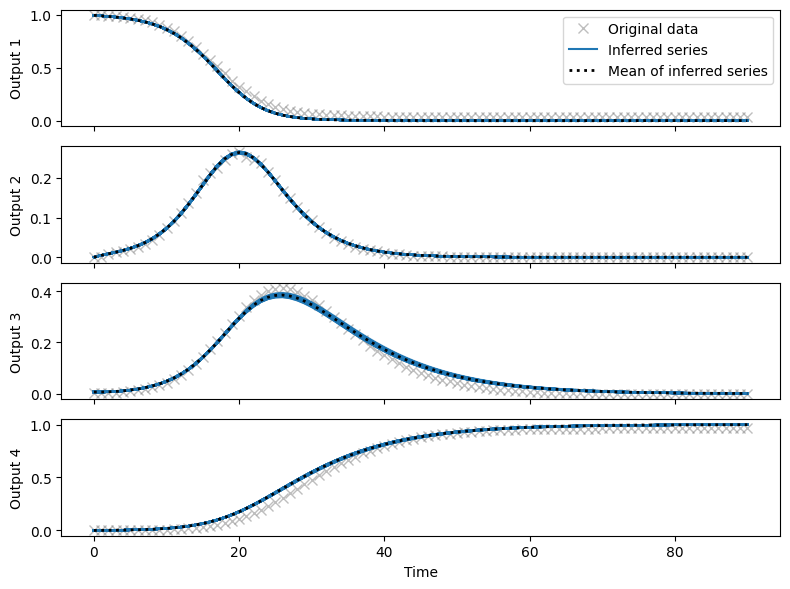

In [120]:
pints.plot.series(chains[0, :], problem)
plt.show()

#### Chain 2

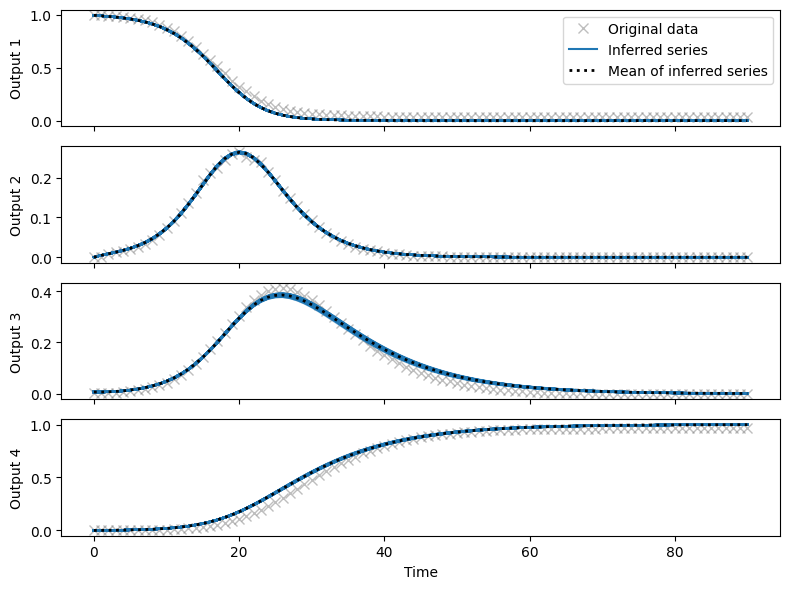

In [121]:
pints.plot.series(chains[1, :], problem)
plt.show()

#### Chain 3

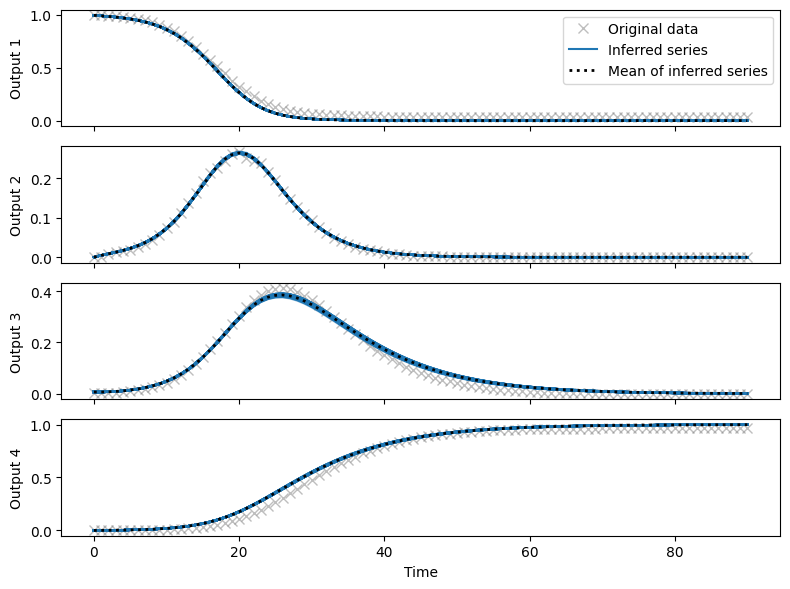

In [122]:
pints.plot.series(chains[2, :], problem)
plt.savefig("inference_outputs/series.png")

#### Chain 4

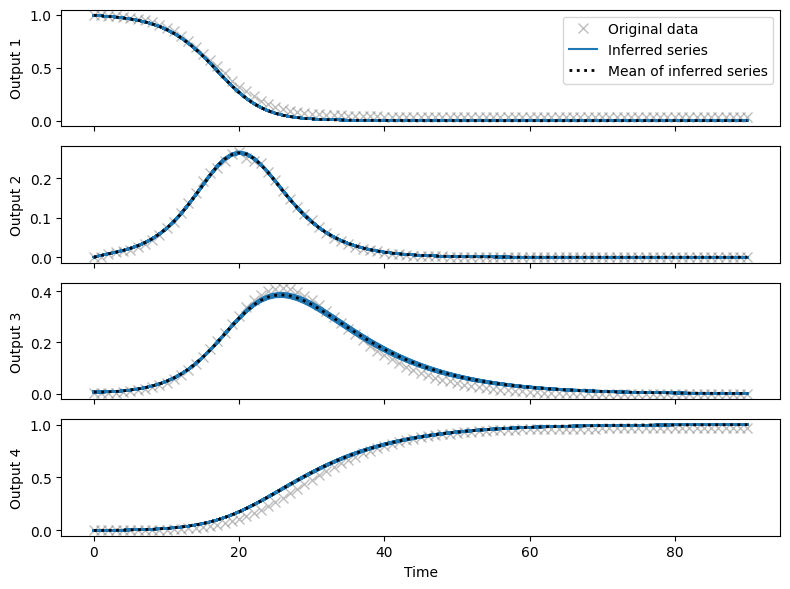

In [123]:
pints.plot.series(chains[3, :], problem)
plt.show()

In [ ]:

print(chains.shape)

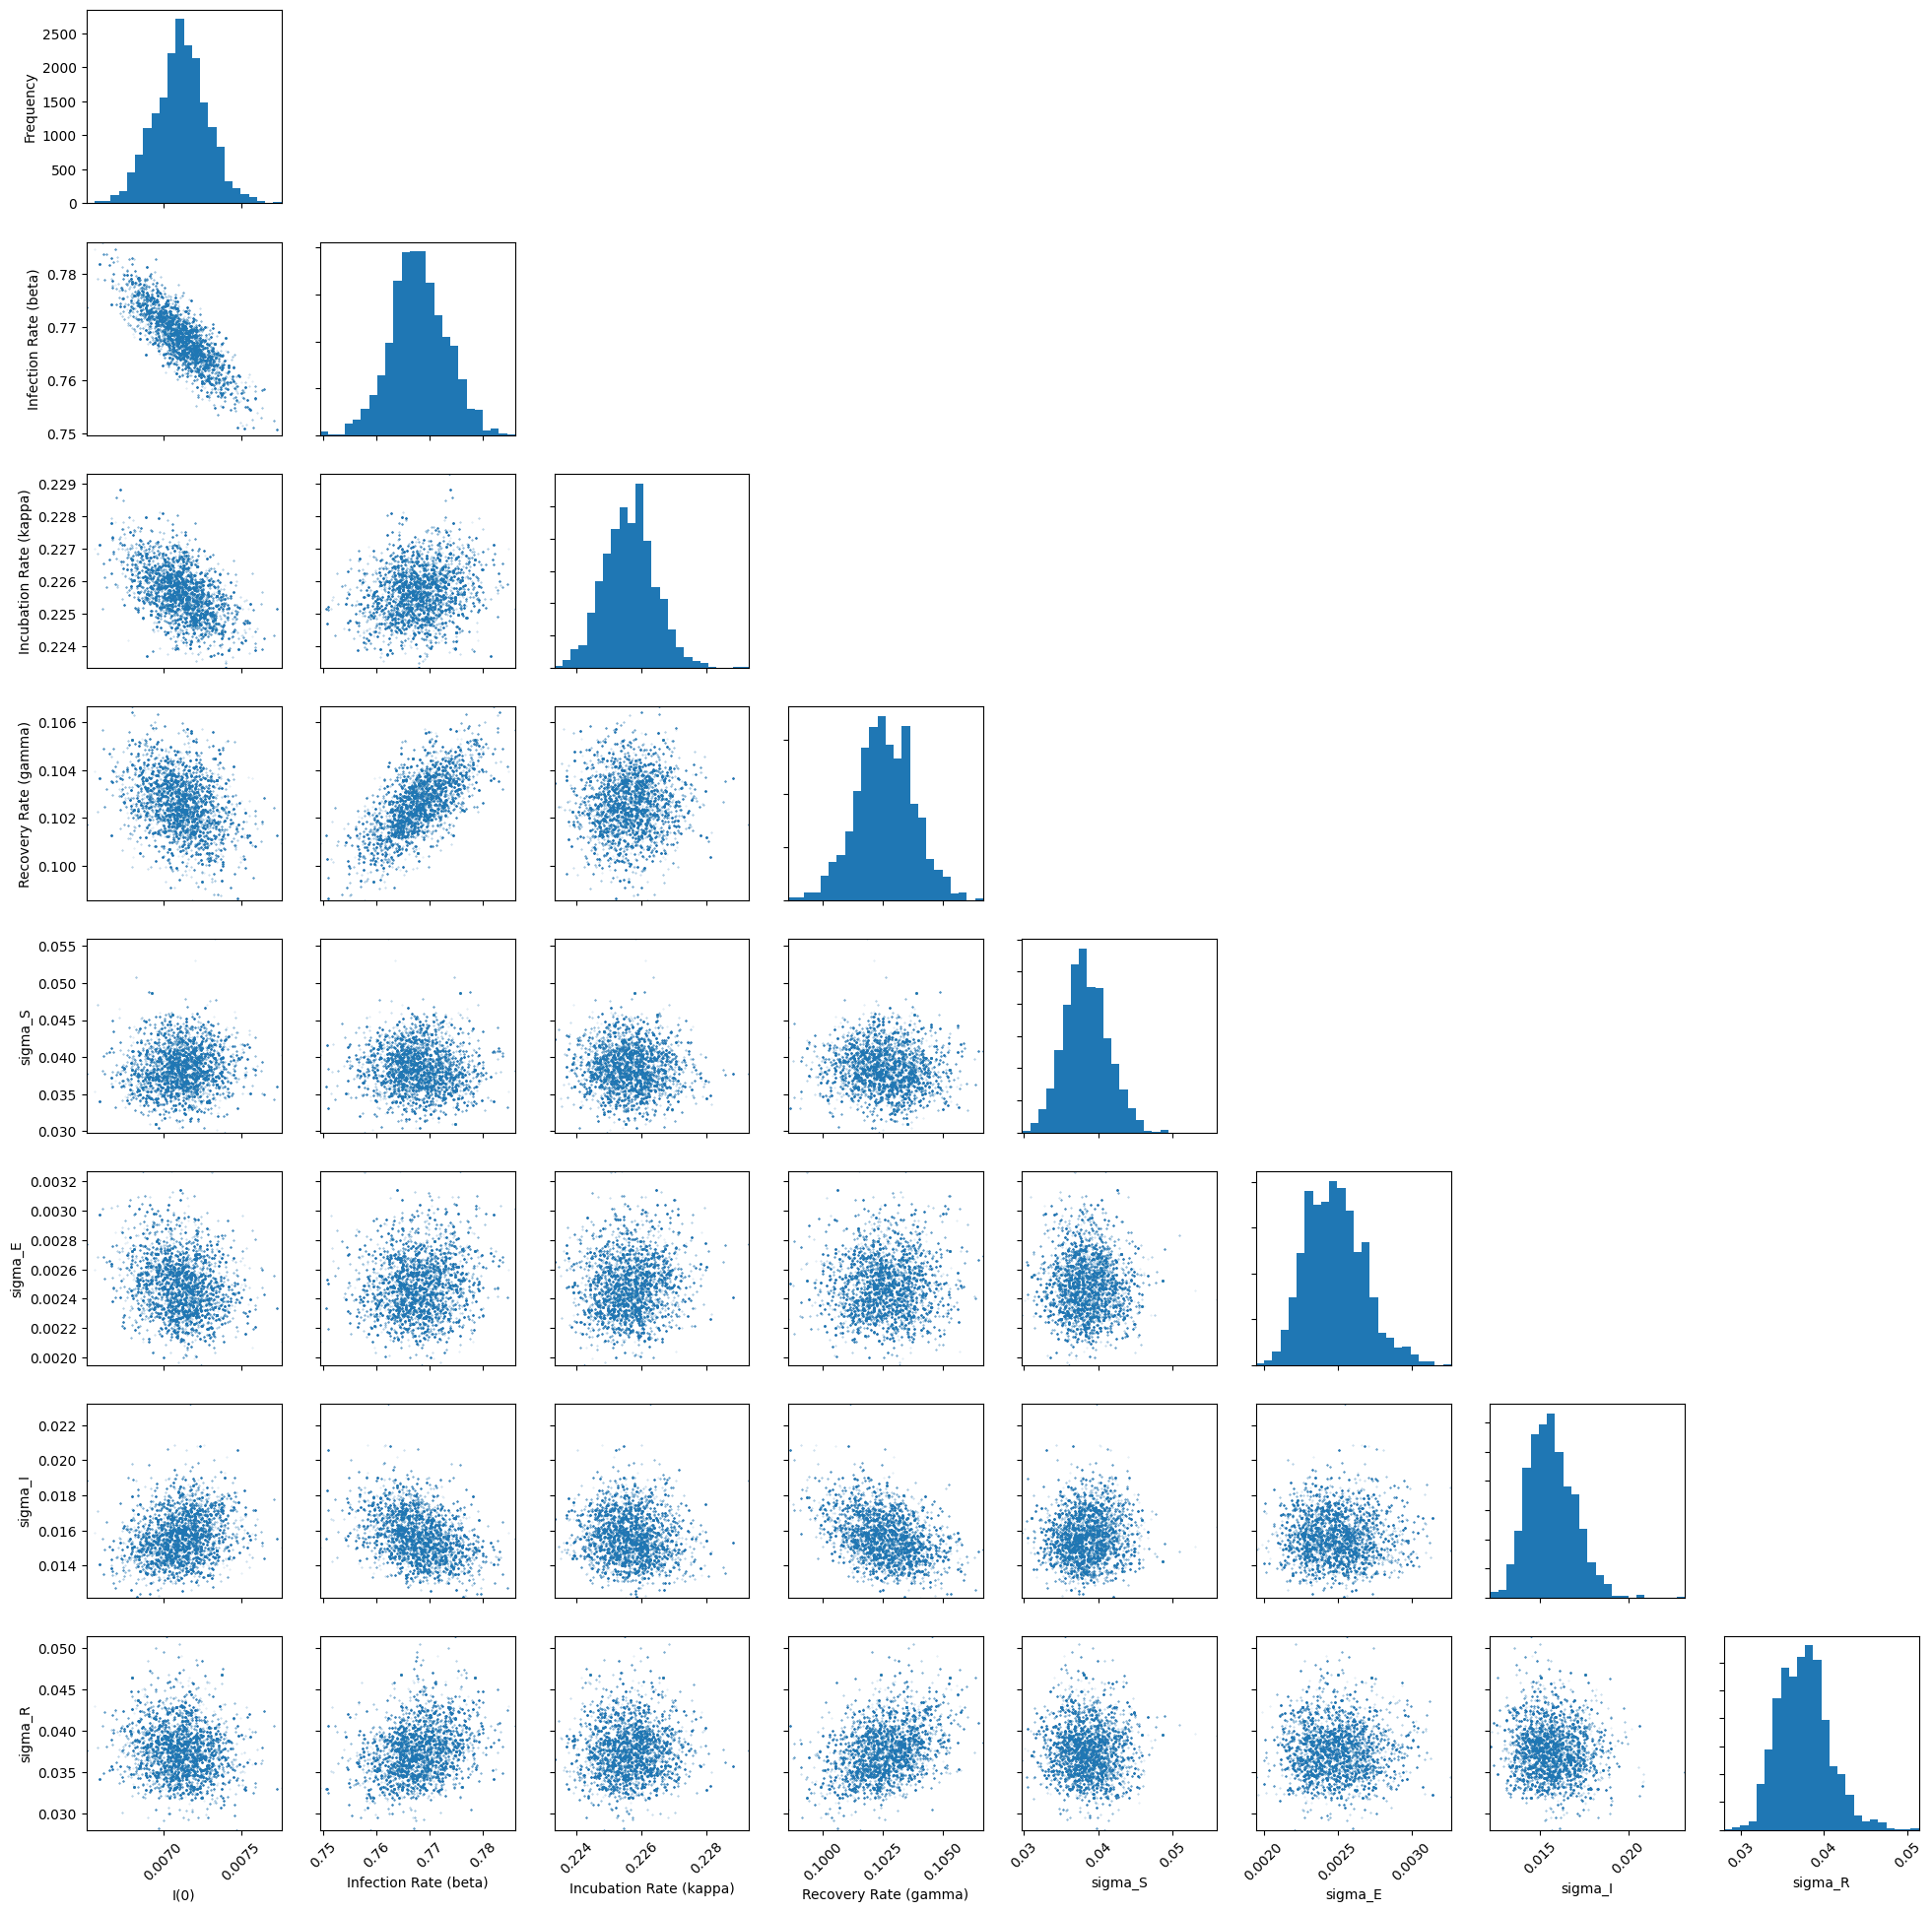

In [124]:
pints.plot.pairwise(chains[0, :], parameter_names=param_names)
plt.savefig("inference_outputs/pairwise_no_ics.png")

## Estimating $R_t$

Now we will move on to estimating the value of $R_t$. The effective reproduction number, $R_t$, is defined as:

$$R_{t} = \frac{\beta}{\gamma N}S(t),$$

where $\beta$ and $\gamma$ are as defined previously, $N$ is the total population and $S(t)$ is the number of susceptible people at time $t$.

### Rescaling and extracting $\beta$ and $\gamma$

In [125]:
chains_df = pd.DataFrame(columns=param_names + ['chain'])
for i in range(4):
    chain_i_df = pd.DataFrame(chains[i], columns=param_names)
    for population_parameter in ["sigma_S", "sigma_E", "sigma_I", "sigma_R"]:
        chain_i_df[population_parameter] = pop_size * chain_i_df[population_parameter]
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_29620\3266292034.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


Mean beta: 0.7675137142553636, std dev beta: 0.005325528602327466
Mean gamma: 0.10244168778999277, std dev gamma: 0.001204811206955916
Mean kappa: 0.22560655070694224, std dev kappa: 0.0008063109061298542


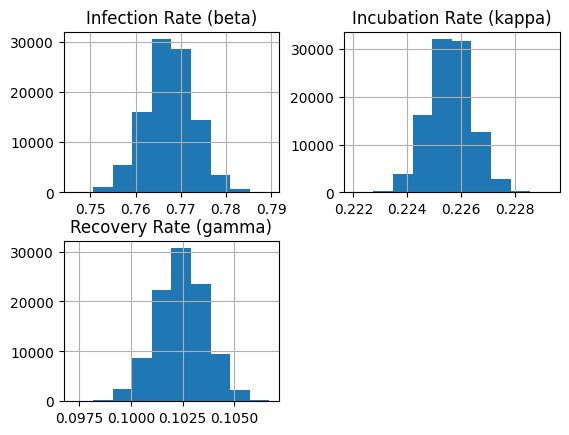

In [131]:
beta_posterior = chains_df["Infection Rate (beta)"].to_numpy()
gamma_posterior = chains_df["Recovery Rate (gamma)"].to_numpy()
kappa_posterior = chains_df["Incubation Rate (kappa)"].to_numpy()
print(f"Mean beta: {np.mean(chains_df["Infection Rate (beta)"])}," 
      f" std dev beta: {np.std(chains_df["Infection Rate (beta)"])}")
print(f"Mean gamma: {np.mean(chains_df["Recovery Rate (gamma)"])}," 
      f" std dev gamma: {np.std(chains_df["Recovery Rate (gamma)"])}")
print(f"Mean kappa: {np.mean(chains_df["Incubation Rate (kappa)"])}," 
      f" std dev kappa: {np.std(chains_df["Incubation Rate (kappa)"])}")
chains_df.hist(column=["Infection Rate (beta)", "Incubation Rate (kappa)", "Recovery Rate (gamma)"])
plt.title("Posterior distributions for the governing parameters")
plt.savefig("inference_outputs/posteriors.png")

In [67]:
import random

### Contingency table for secondary infections

In [101]:
times = secondary_infections_data["time"]
times_repeated = np.repeat(times, pop_size)
secondary_infections = secondary_infections_data.iloc[:, 1:-1].to_numpy().flatten()
contingency = pd.crosstab(times_repeated, secondary_infections, rownames=["Time"],
                          colnames=["Frequency"])
contingency_array = contingency.iloc[:, :16].to_numpy().transpose()

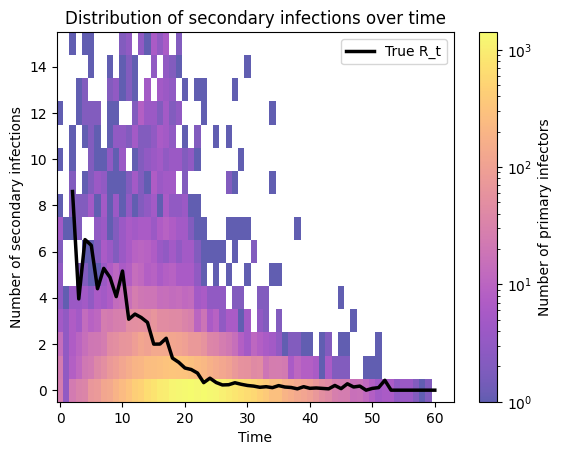

In [102]:
active_times = np.arange(-0.5, 60, 1)
frequencies = np.arange(-0.5, 16, 1)
fig, ax = plt.subplots()
cf = ax.pcolormesh(active_times, frequencies, contingency_array,
                   alpha=0.65, cmap='plasma',
                   norm=matplotlib.colors.LogNorm())
ax.plot(secondary_infections_data["time"][:61], secondary_infections_data["R_t"][:61], 'k', 
        lw=2.5, label="True R_t")
fig.colorbar(cf, label="Number of primary infectors")
ax.set_xlabel("Time")
ax.set_ylabel("Number of secondary infections")
ax.set_title("Distribution of secondary infections over time")
ax.legend()
fig.savefig("gibraltar_outputs/secondary_infections_mesh.png")

### Plotting expected and actual $R_t$ values

In [5]:
# cf = plt.pcolormesh(active_times, frequencies, contingency_array,
#                alpha=0.8, cmap='viridis',
#                norm=matplotlib.colors.LogNorm())
R_t_list = []
num_samples = 100
for j in range(num_samples):
    k = random.randint(0, len(beta_posterior))
    R_t_list.append(beta_posterior[k] / (gamma_posterior[k] * pop_size) * susceptible)
    if j == 0:
        plt.plot(secondary_infections_data["time"][:61], R_t_list[j][:61], 'b', label="Inferred series (n = 100)")
    else:
        plt.plot(secondary_infections_data["time"][:61], R_t_list[j][:61], 'b', alpha=0.1)
mean_R_t = np.mean(np.array(R_t_list), axis=0)
std_dev_R_t = np.std(np.array(R_t_list), axis=0)
plt.plot(secondary_infections_data["time"][:61], secondary_infections_data["R_t"][:61], 'k', 
         label="True series")
plt.plot(secondary_infections_data["time"][:61], mean_R_t[:61], '--r', label="Mean of inferred series")
plt.xlabel("Time")
plt.ylabel("R_t")
plt.title("R_t values over time for Gibraltar simulation")
plt.legend()
# plt.colorbar(cf)
# plt.show()
# plt.savefig("inference_outputs/inferred_R_t_I0_inferred.png")

NameError: name 'random' is not defined